In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ruptures as rpt
import seaborn as sns

In [31]:
#utils

def bwl(y,theta,K):
    
    if np.abs(y-theta) <= K:
        return (y-theta)**2
    else:
        return K**2
    
def add_outliers(n_outliers,signal):
    
    sig_length = signal.size
    outliers = np.random.choice(np.arange(1,sig_length),n_outliers,replace=False)
    print(outliers)
    signal[outliers] += 6*signal.mean()
    
    return signal

In [33]:
n_samples, n_dims, sigma = 1000, 1, 2
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, n_dims, n_bkps, noise_std=sigma)

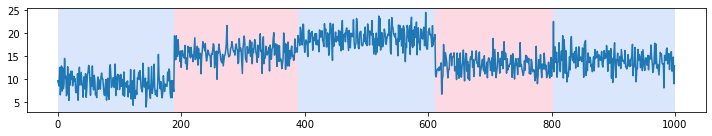

In [34]:
fig, ax_array = rpt.display(signal, bkps)

In [35]:
new_sig = add_outliers(5,signal)

[ 56 153 513  78 545]


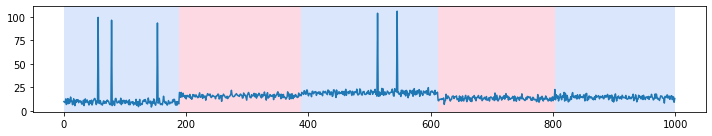

In [36]:
fig, ax_array = rpt.display(new_sig, bkps)